<a href="https://colab.research.google.com/github/liminovna/HSE_NLP_ASSIGNMENTS/blob/main/module3_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 2 модели, похожие по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте поклассовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [ ]:
! wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
! unzip -o lenta_40k.csv.zip

--2025-03-22 13:04:07--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip [following]
--2025-03-22 13:04:07--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip.3’

lenta_40k.csv.zip.3 100%[===================>]  29.24M   112MB/s    in 0.3s    

2025-03-22 13:04:08 (112 MB/s) - ‘lenta_40k.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('lenta_40k.csv')
df

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [ ]:
df.describe(include='all')

,text,topic
count,44356,44356
unique,44319,19
top,"РИА ""Новости""",Россия
freq,20,9622


In [ ]:
from collections import Counter
from string import punctuation

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

# словарь
vocab = Counter()

for text in df.text:
    vocab.update(preprocess(text))
print('vocab:', len(vocab))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
print('filtered:', len(filtered_vocab))

vocab: 354611
filtered: 24091


In [ ]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)


id2word = {i:word for word, i in word2id.items()}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):

        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)

        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить

        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [ ]:
MAX_LEN = 200

In [ ]:
texts = df.text.values
id2label = {i:l for i,l in enumerate(set(df.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in df.topic]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [ ]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [ ]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            preds_ = model(texts.to(device))
            predictions = preds_.squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1) # np.mean(epoch_f1) / len(iterator)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.metrics import classification_report

### Модель 1

In [ ]:
# Модель с тремя рекуррентными слоями. Финальный вектор для классификации состоит из последнего состояния RNN,
# а также AveragePooling и MaxPooling из всех векторов последовательности.

class Clf(nn.Module):

    def __init__(self, output_dim):

        super().__init__()
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 50
        self.RNN_UNITS = 128


        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, num_layers=3,
                           batch_first=True)
        self.avg_pool = nn.AvgPool1d(self.RNN_UNITS, output_dim)
        self.max_pool = nn.MaxPool1d(self.RNN_UNITS, output_dim)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)
        self.act = nn.LogSoftmax(1)


    def forward(self, text):

        embedded = self.embedding(text)

        rnn_output, (h, *_) = self.rnn(embedded) # применяем rnn слой

        pool_avg_output = self.avg_pool(h[-1]) # применяем AveragePooling
        pool_max_output = self.max_pool(h[-1]) # применяем MaxPooling

        # тут тоже будет трехмерный h
        # но первый будет не 1 а равный num_layers
        # мы возьмем последний с помощью индекса -1
        # squeeze(0) тут не нужен и его и не получится применить
        # output = torch.cat((self.fc(h[-1]),self.fc(pool_avg_output)), dim=1)
        output = torch.cat((self.fc(h[-1]),pool_avg_output,pool_max_output), dim=1)
        return self.act(output)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Clf(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.350881090164185; F1 measure: 0.2112890625
Eval -  0.21079452614379085
1
Loss: 2.291395490169525; F1 measure: 0.2146875
Eval -  0.26097324346405226
2
Loss: 2.1170758056640624; F1 measure: 0.2678125
Eval -  0.29374489379084967
3
Loss: 1.9760443878173828; F1 measure: 0.2971484375
Eval -  0.3389093137254902
4
Loss: 1.8723946011066437; F1 measure: 0.341953125
Eval -  0.39815665849673204
5
Loss: 1.6932156085968018; F1 measure: 0.41390625
Eval -  0.44203431372549024
6
Loss: 1.5502253007888793; F1 measure: 0.485390625
Eval -  0.4904258578431373
7
Loss: 1.4453224194049836; F1 measure: 0.5351171875
Eval -  0.5447099673202614
8
Loss: 1.3379434382915496; F1 measure: 0.5746875
Eval -  0.5781658496732026
9
Loss: 1.2324805426597596; F1 measure: 0.622265625
Eval -  0.5946435866013071


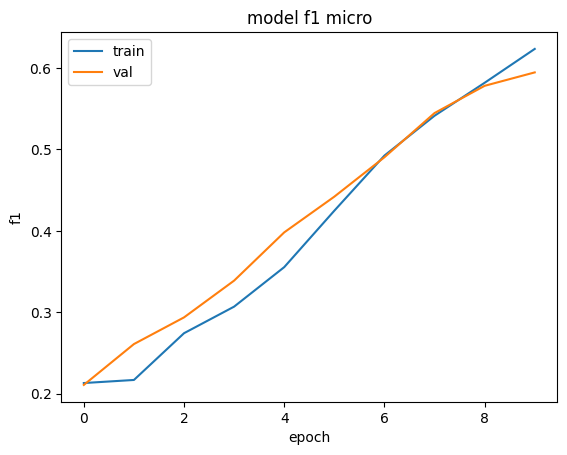

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# сплющиваем последовательности классов в 1 последовательность и
# считаем метрики как будто это обычная классификация
pred = model(valid_set.texts.to(device)).argmax(1).detach().cpu()
print(classification_report(valid_set.target.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                             target_names=id2label.values(),
                                                                             zero_division=0))

                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         0
           Бизнес       0.00      0.00      0.00        20
         Культура       0.61      0.71      0.66       160
      Бывший СССР       0.63      0.49      0.55       142
         Из жизни       0.20      0.04      0.07        91
              Мир       0.55      0.75      0.63       410
Силовые структуры       0.00      0.00      0.00        51
           Россия       0.59      0.68      0.63       471
      Путешествия       0.00      0.00      0.00        26
   69-я параллель       0.00      0.00      0.00         1
            Спорт       0.92      0.94      0.93       208
        Экономика       0.64      0.83      0.72       242
              Дом       0.00      0.00      0.00        60
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.42      0.66      0.51       

### Модель 2

In [ ]:
# Двунаправленная модель с тремя рекуррентными слоями. Финальный вектор для классификации состоит из последнего состояния RNN,
# а также AveragePooling и MaxPooling из всех векторов последовательности.
class ClfBidirectional(nn.Module):

    def __init__(self, output_dim):

        super().__init__()
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 50
        self.RNN_UNITS = 128


        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)

        self.avg_pool = nn.AvgPool1d(self.RNN_UNITS, output_dim)
        self.max_pool = nn.MaxPool1d(self.RNN_UNITS, output_dim)

        # через параметр делается вот так, а в forward будет точно также как в сетке выше
        self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, num_layers=3,
                           batch_first=True, bidirectional=True)

        # bidirectional создает 2 вектора размерности unit, соответственно на следующем слое умножаем размерность на 2
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1)


    def forward(self, text):

        embedded = self.embedding(text)

        rnn_output, (h, *_) = self.rnn(embedded) # применяем rnn слой

        pool_avg_output = self.avg_pool(h[-1]) # применяем AveragePooling
        pool_max_output = self.max_pool(h[-1]) # применяем MaxPooling

        # тут тоже будет трехмерный h
        # но первый будет не 1 а равный num_layers
        # мы возьмем последний с помощью индекса -1
        # squeeze(0) тут не нужен и его и не получится применить
        # output = torch.cat((self.fc(h[-1]),self.fc(pool_avg_output)), dim=1)
        output = torch.cat((self.fc(h[-1]),pool_avg_output,pool_max_output), dim=1)
        return self.act(output)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClfBidirectional(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Loss: 2.3983746004104614; F1 measure: 0.21109375
Eval -  0.31241830065359477
1
Loss: 1.9177881932258607; F1 measure: 0.3514453125
Eval -  0.40293096405228757
2
Loss: 1.670401303768158; F1 measure: 0.4334765625
Eval -  0.49676776960784313
3
Loss: 1.4652382397651673; F1 measure: 0.530078125
Eval -  0.5829452614379085
4
Loss: 1.2687836110591888; F1 measure: 0.6090625
Eval -  0.630453431372549
5
Loss: 1.1291658037900925; F1 measure: 0.656953125
Eval -  0.6552083333333333
6
Loss: 1.038425115942955; F1 measure: 0.6887109375
Eval -  0.6932240604575164
7
Loss: 0.9284522169828415; F1 measure: 0.7244140625
Eval -  0.6960529003267975
8
Loss: 0.8597545737028122; F1 measure: 0.7468359375
Eval -  0.7116830065359477
9
Loss: 0.8032353502511979; F1 measure: 0.7600390625
Eval -  0.7116676879084968


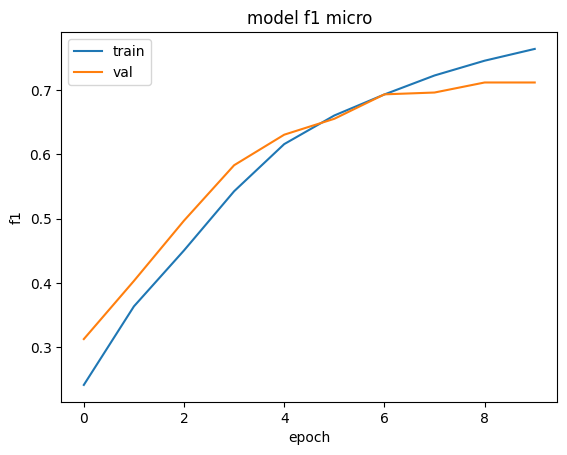

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# сплющиваем последовательности классов в 1 последовательность и
# считаем метрики как будто это обычная классификация
pred = model(valid_set.texts.to(device)).argmax(1).detach().cpu()
print(classification_report(valid_set.target.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                             target_names=id2label.values(),
                                                                             zero_division=0))

                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         0
           Бизнес       0.00      0.00      0.00        20
         Культура       0.82      0.61      0.70       160
      Бывший СССР       0.75      0.73      0.74       142
         Из жизни       0.35      0.31      0.33        91
              Мир       0.72      0.83      0.77       410
Силовые структуры       0.25      0.02      0.04        51
           Россия       0.70      0.83      0.76       471
      Путешествия       0.00      0.00      0.00        26
   69-я параллель       0.00      0.00      0.00         1
            Спорт       0.91      0.94      0.93       208
        Экономика       0.74      0.81      0.77       242
              Дом       0.90      0.62      0.73        60
             Крым       0.00      0.00      0.00         0
  Наука и техника       0.77      0.69      0.73       

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  

1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM

2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать

3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("tner/wikiann", 'ru')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

In [ ]:
from collections import Counter

In [ ]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [ ]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()}

In [ ]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_plot(f1s, f1s_eval):
  plt.plot(f1s)
  plt.plot(f1s_eval)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids], maxlen=max_len, padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [ ]:
additional_sents = [
    'томский журналист Игорь Кузнецов, приговорённый Бутырским судом Москвы к шести годам лишения свободы за организацию массовых беспорядков (которых не было), покинул СИЗО-4 г. Москвы и был отправлен на этап в исправительную колонию'
]

### 1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru = keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm = keras.layers.LSTM(128, return_sequences=True)(gru)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.8547 - loss: 0.5836 - val_accuracy: 0.9433 - val_loss: 0.1909
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.9467 - loss: 0.1645 - val_accuracy: 0.9660 - val_loss: 0.0998
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9755 - loss: 0.0717 - val_accuracy: 0.9718 - val_loss: 0.0816
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.9867 - loss: 0.0396 - val_accuracy: 0.9689 - val_loss: 0.0878
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.9943 - loss: 0.0226 - val_accuracy: 0.9718 - val_loss: 0.0896


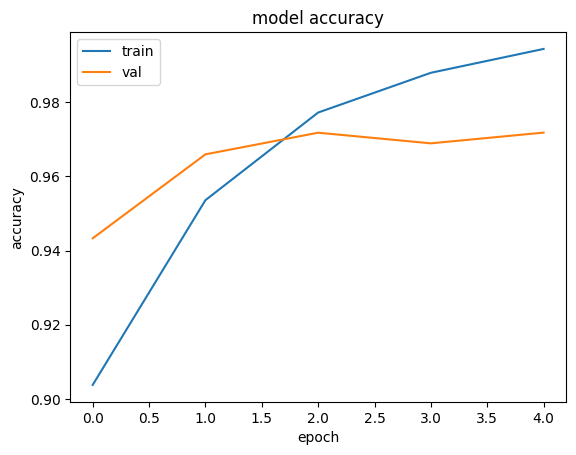

In [ ]:
f1s = model.history.history['accuracy']
f1s_eval = model.history.history['val_accuracy']

get_plot(f1s, f1s_eval)

In [ ]:
pred = model.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step


In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.59      0.64      0.61      4560
       B-ORG       0.48      0.62      0.54      4074
       B-PER       0.69      0.31      0.42      3542
       I-LOC       0.84      0.57      0.67      3060
       I-ORG       0.51      0.80      0.62      8008
       I-PER       0.90      0.71      0.80      7544
           O       0.92      0.88      0.90     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.74      0.69      0.70    540000
weighted avg       0.97      0.97      0.97    540000



In [ ]:
for s in additional_sents:
  print(*label_seq(s, word2id, id2labels, MAX_LEN, model), sep='\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[('томский', 'B-ORG'),
 ('журналист', 'O'),
 ('Игорь', 'I-ORG'),
 ('Кузнецов', 'I-PER'),
 (',', 'I-PER'),
 ('приговорённый', 'I-PER'),
 ('Бутырским', 'I-ORG'),
 ('судом', 'I-ORG'),
 ('Москвы', 'I-ORG'),
 ('к', 'O'),
 ('шести', 'O'),
 ('годам', 'O'),
 ('лишения', 'O'),
 ('свободы', 'I-ORG'),
 ('за', 'O'),
 ('организацию', 'O'),
 ('массовых', 'O'),
 ('беспорядков', 'O'),
 ('(', 'O'),
 ('которых', 'O'),
 ('не', 'O'),
 ('было', 'O'),
 ('),', 'O'),
 ('покинул', 'O'),
 ('СИЗО', 'B-ORG'),
 ('-', 'O'),
 ('4', 'O'),
 ('г', 'O'),
 ('.', 'O'),
 ('Москвы', 'B-LOC'),
 ('и', 'O'),
 ('был', 'O'),
 ('отправлен', 'O'),
 ('на', 'O'),
 ('этап', 'O'),
 ('в', 'O'),
 ('исправительную', 'B-LOC'),
 ('колонию', 'I-ORG')]

### 2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 155s 979ms/step - accuracy: 0.8618 - loss: 0.5766 - val_accuracy: 0.9448 - val_loss: 0.1845
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 909ms/step - accuracy: 0.9498 - loss: 0.1590 - val_accuracy: 0.9666 - val_loss: 0.0983
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 935ms/step - accuracy: 0.9753 - loss: 0.0734 - val_accuracy: 0.9710 - val_loss: 0.0823
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 911ms/step - accuracy: 0.9868 - loss: 0.0428 - val_accuracy: 0.9736 - val_loss: 0.0781
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9935 - loss: 0.0257 - val_accuracy: 0.9730 - val_loss: 0.0824


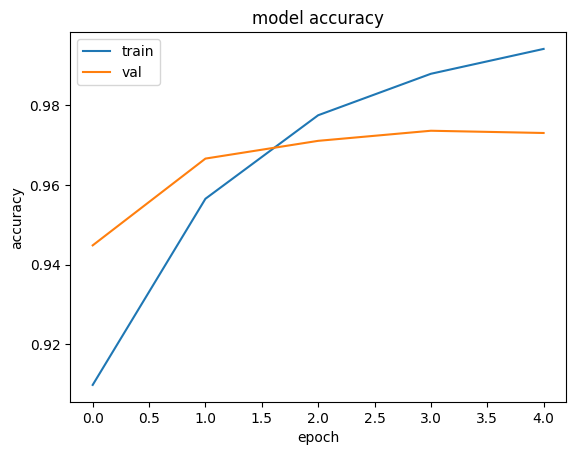

313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 184ms/step
              precision    recall  f1-score   support

       B-LOC       0.66      0.58      0.61      4560
       B-ORG       0.47      0.58      0.52      4074
       B-PER       0.72      0.44      0.55      3542
       I-LOC       0.86      0.55      0.67      3060
       I-ORG       0.48      0.85      0.62      8008
       I-PER       0.91      0.85      0.88      7544
           O       0.95      0.87      0.91     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.76      0.72      0.72    540000
weighted avg       0.98      0.97      0.97    540000



In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru = keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_1 = keras.layers.LSTM(128, return_sequences=True)(gru)
resid_1 = keras.layers.concatenate((lstm_1, embeddings))
lstm_2 = keras.layers.LSTM(128, return_sequences=True)(lstm_1)
resid_2 = keras.layers.concatenate((lstm_2, embeddings))

outputs = keras.layers.Dense(len(label2id), activation='softmax')(resid_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)
f1s = model.history.history['accuracy']
f1s_eval = model.history.history['val_accuracy']

get_plot(f1s, f1s_eval)
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

In [ ]:
for s in additional_sents:
  print(*label_seq(s, word2id, id2labels, MAX_LEN, model), sep='\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
('томский', 'I-ORG')
('журналист', 'O')
('Игорь', 'B-PER')
('Кузнецов', 'I-PER')
(',', 'I-PER')
('приговорённый', 'I-PER')
('Бутырским', 'I-PER')
('судом', 'I-ORG')
('Москвы', 'I-ORG')
('к', 'O')
('шести', 'O')
('годам', 'O')
('лишения', 'B-ORG')
('свободы', 'I-ORG')
('за', 'I-ORG')
('организацию', 'O')
('массовых', 'I-ORG')
('беспорядков', 'O')
('(', 'O')
('которых', 'O')
('не', 'O')
('было', 'O')
('),', 'O')
('покинул', 'O')
('СИЗО', 'O')
('-', 'O')
('4', 'O')
('г', 'O')
('.', 'O')
('Москвы', 'B-ORG')
('и', 'O')
('был', 'O')
('отправлен', 'O')
('на', 'O')
('этап', 'O')
('в', 'O')
('исправительную', 'O')
('колонию', 'I-ORG')


### 3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 692ms/step - accuracy: 0.8597 - loss: 0.5411 - val_accuracy: 0.9471 - val_loss: 0.1671
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 104s 665ms/step - accuracy: 0.9566 - loss: 0.1329 - val_accuracy: 0.9750 - val_loss: 0.0759
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 102s 648ms/step - accuracy: 0.9844 - loss: 0.0474 - val_accuracy: 0.9793 - val_loss: 0.0648
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 95s 603ms/step - accuracy: 0.9939 - loss: 0.0209 - val_accuracy: 0.9805 - val_loss: 0.0689
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 600ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9809 - val_loss: 0.0721


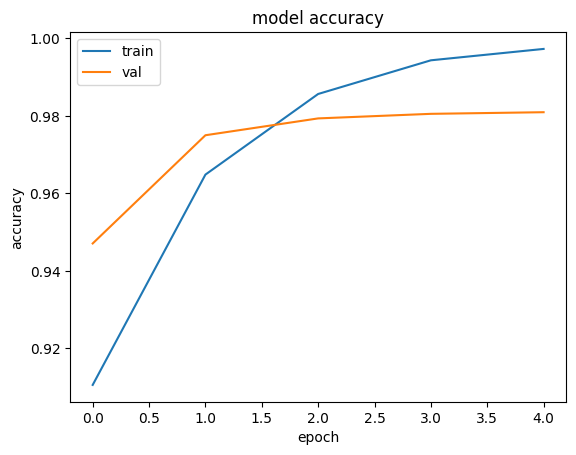

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 123ms/step
              precision    recall  f1-score   support

       B-LOC       0.84      0.68      0.75      4560
       B-ORG       0.45      0.76      0.57      4074
       B-PER       0.77      0.80      0.79      3542
       I-LOC       0.89      0.72      0.79      3060
       I-ORG       0.73      0.81      0.76      8008
       I-PER       0.93      0.87      0.90      7544
           O       0.95      0.91      0.93     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.82      0.81    540000
weighted avg       0.98      0.98      0.98    540000



In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

conv_1 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(embeddings)
conv_2 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(conv_1)
gru = keras.layers.GRU(128, return_sequences=True)(conv_2)
lstm = keras.layers.LSTM(128, return_sequences=True)(gru)


outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)
f1s = model.history.history['accuracy']
f1s_eval = model.history.history['val_accuracy']

get_plot(f1s, f1s_eval)
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

In [ ]:
for s in additional_sents:
  print(*label_seq(s, word2id, id2labels, MAX_LEN, model), sep='\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
('томский', 'B-ORG')
('журналист', 'I-ORG')
('Игорь', 'I-ORG')
('Кузнецов', 'I-PER')
(',', 'O')
('приговорённый', 'B-ORG')
('Бутырским', 'I-ORG')
('судом', 'O')
('Москвы', 'I-ORG')
('к', 'O')
('шести', 'O')
('годам', 'O')
('лишения', 'O')
('свободы', 'O')
('за', 'O')
('организацию', 'O')
('массовых', 'O')
('беспорядков', 'O')
('(', 'O')
('которых', 'O')
('не', 'O')
('было', 'O')
('),', 'O')
('покинул', 'O')
('СИЗО', 'O')
('-', 'O')
('4', 'O')
('г', 'O')
('.', 'O')
('Москвы', 'B-ORG')
('и', 'O')
('был', 'O')
('отправлен', 'O')
('на', 'O')
('этап', 'O')
('в', 'O')
('исправительную', 'B-ORG')
('колонию', 'I-ORG')
